In [ ]:
!pip install catboost

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from mlfinpy.util.frac_diff import frac_diff_ffd, plot_min_ffd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [ ]:
data = pd.read_csv('CLOSE.csv')
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
# data1 = pd.DataFrame({'close' : np.array(data['SBER'])}, index=data['datetime'])
  # ИЛИ
open = pd.read_csv('OPEN.csv')
low = pd.read_csv('LOW.csv')
high = pd.read_csv('HIGH.csv')
volume = pd.read_csv('VOLUME.csv')
data_orig = pd.concat([data[['timestamp', 'SBER']], open['SBER'], low['SBER'], high['SBER'], volume['SBER']], axis=1)
data_orig.columns = ['timestamp', 'close', 'open', 'low', 'high', 'volume']

data = pd.Series(np.array(data['SBER']), index=data['datetime'], name='close')
data_orig.index = data.index
print(data.head())

datetime
2019-01-03 06:00:00    186.37
2019-01-03 07:00:00    188.52
2019-01-03 08:00:00    190.29
2019-01-03 09:00:00    189.44
2019-01-03 10:00:00    189.67
Name: close, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from typing import Sequence, Optional, Callable
from functools import reduce

Feature = Callable[[pd.DataFrame], pd.DataFrame]


def get_price_series(df: pd.DataFrame) -> pd.Series:
    assert "timestamp" in df.columns, "DataFrame must contain 'timestamp' column"

    price_cols = [col for col in df.columns if col != "timestamp"]
    if len(price_cols) != 1:
        raise ValueError(
            f"Expected exactly 1 non-'timestamp' column, got {len(price_cols)}: {price_cols}"
        )

    return df[price_cols[0]].astype(float)


def choose_alpha_with_mse(s: pd.Series) -> float:
    y = s.dropna().to_numpy(dtype=float)

    def mse_for_alpha(a: float) -> float:
        prev_y = y[0]
        mse_sum = 0.0
        for i in range(1, y.size):
            mse_sum += (prev_y - y[i]) ** 2
            prev_y = a * y[i] + (1.0 - a) * prev_y

        return mse_sum

    grid = np.linspace(0.01, 0.99, 99)
    mses = [mse_for_alpha(a) for a in grid]
    return grid[np.argmin(mses)]


def rolling_features(
    df: pd.DataFrame,
    window: int,
    weights: Optional[Sequence[float]] = None,
    alpha: Optional[float] = None,
) -> pd.DataFrame:
    s = get_price_series(df)

    if alpha is not None:
        if not (0.0 < alpha < 1.0):
            raise ValueError("alpha must be between 0 and 1 (exclusive)")
    elif window <= 100:
        alpha = 0.9
    else:
        alpha = choose_alpha_with_mse(s)

    roll = s.shift(1).rolling(window=window, min_periods=window)
    if weights is None:
        weights = np.arange(1, window + 1, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if len(weights) != window:
            raise ValueError("len(weights) must equal window size")

    features = pd.DataFrame(index=s.index)
    features["mean"] = roll.mean()
    features["weighted_mean"] = roll.apply(
        lambda x: np.average(x, weights=weights[-len(x) :]), raw=True
    )
    features["exp_smooth"] = roll.apply(
        lambda x: reduce(lambda s, v: alpha * v + (1.0 - alpha) * s, x[1:], x[0]),
        raw=True,
    )
    features["median"] = roll.median()
    features["min"] = roll.min()
    features["max"] = roll.max()
    features["std"] = roll.std()
    return features


In [ ]:
class STLModel:
  def __init__(self,
               data: pd.Series,
               log_smooth: bool = True,
               seasonal_smooth: int = 23,
               seasonal_periods: int = 15
               ):
    '''data(pd.Series): Индекс обязательно должен быть в формате datetime!!!!!!!!!'''
    self.data = np.log(data) if log_smooth else data
    self.original_data = data
    self.log_smooth = log_smooth


    '''
      seasonal_smooth(int): Length of the seasonal smoother. Must be an odd integer, and should
      normally be >= 7 (default).
    '''
    self.seasonal_smooth = seasonal_smooth

    '''
      seasonal_periods(int): Количество периодов в полном цикле сезонности.
    '''
    self.seasonal_periods = seasonal_periods

    self.model = STL(
          self.data,
          period=self.seasonal_periods,
          seasonal=seasonal_smooth,
          robust=True
      )

  def fit(self):
    try:
        self.model = self.model.fit()
        return self

    except (RuntimeWarning, ValueError, FloatingPointError) as e:
        return None
    except Exception as e:
        return None

  def get_components(self, make_plot=False, last_ticks_plot=100):
      if last_ticks_plot is None:
          last_ticks_plot = len(self.data)

      trend = self.model.trend
      seasonal = self.model.seasonal
      residual = self.model.resid

      components = pd.DataFrame(
          np.c_[trend, seasonal, residual],
          columns=["trend", "seasonal", "residual"],
          index=self.data.index,
      )

      if make_plot:
          self.plot_trend_seasonal_residual(components, is_log=self.log_smooth, last_ticks_plot=last_ticks_plot)

      return components


  @staticmethod
  def plot_trend_seasonal_residual(components, is_log=False, last_ticks_plot=100):
    dates = components.index

    if is_log:
      trend = np.exp(components['trend'])
      residual = np.exp(components['residual'])
      seasonal_multiplier= np.exp(components['seasonal'])
      seasonal_pct = (seasonal_multiplier - 1) * 100
    else:
      trend = components['trend']
      residual = components['residual']
      seasonal_pct = (components['seasonal'] / trend) * 100

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

    ax1.plot(dates[-last_ticks_plot:], trend[-last_ticks_plot:], ls='-.')
    ax1.set_title('Trend')

    ax2.plot(dates[-last_ticks_plot:], seasonal_pct[-last_ticks_plot:], ls='--')
    ax2.set_title('Seasonal')

    ax3.plot(dates[-last_ticks_plot:], residual[-last_ticks_plot:], ls='--')
    ax3.set_title('Residual')

    plt.suptitle('Trend, seasonal and residual')
    plt.show()

  def reconstruct(self, components, last_tick_plot=100, original=None, make_compare_plot=False):
    if components is None:
        components = self.get_components(make_plot=False)
    dates = components.index

    trend = components['trend']
    seasonal = components['seasonal']
    residual = components['residual']

    if self.log_smooth:
        reconstructed = np.exp(trend + seasonal + residual)
    else:
        reconstructed = trend + seasonal + residual


    reconstructed_series = pd.Series(
        reconstructed.values.flatten() if hasattr(reconstructed, 'values') else reconstructed,
        index=dates,
        name='reconstructed'
    )

    if make_compare_plot:
      self.plot_prices_compare(dates, reconstructed, original, period=last_tick_plot)

    return reconstructed_series


  @staticmethod
  def plot_prices_compare(dates, reconstructed, original, period=100):
    plt.figure(figsize=(15, 10))
    plt.plot(dates[-period:], reconstructed[-period:], label='reconstructed',ls='-.')
    plt.plot(dates[-period:], original[-period:], label='original', ls='--')
    plt.legend()
    plt.title('Compare price reconstruction')
    plt.show()


In [ ]:

class FracDiffModel:
  def __init__(self,
               data: pd.DataFrame,
               log_smooth: bool = True,
               diff_amt: float = 0.5,
               thresh=1e-5
               ):
    '''data(pd.DataFrame): Индекс обязательно должен быть в формате datetime!!!!!!!!!'''

    if isinstance(data, pd.Series):
        data = data.to_frame(name='close')
    elif isinstance(data, pd.DataFrame):
        if data.shape[1] != 1:
            raise ValueError("DataFrame должен содержать ровно одну колонку")
    else:
        raise ValueError("data должен быть Series или DataFrame")



    self.data = np.log(data) if log_smooth else data
    self.original_data = data
    self.log_smooth = log_smooth
    self.thresh = thresh

    '''
      diff_amt(float): Differencing amount.
    '''
    self.diff_amt = diff_amt


  def fit(self):
    try:
        self.frac_diff_series = frac_diff_ffd(self.data, self.diff_amt, thresh=self.thresh)
        return self

    except (RuntimeWarning, ValueError, FloatingPointError) as e:
        raise e
        return None
    except Exception as e:
        raise e
        return None

  def get_components(self, make_plot=False, last_ticks_plot=100):
      if last_ticks_plot is None:
          last_ticks_plot = len(self.data)

      residual = self.frac_diff_series.iloc[:, 0]
      components = pd.DataFrame({'residual': residual}, index=self.data.index)

      if make_plot:
          plt.figure(figsize=(10, 8))
          plt.plot(components.index[-last_ticks_plot:], components[-last_ticks_plot:]['residual'], label='residual')
          plt.suptitle('Fractional diff result')
          plt.show()
      return components

  def plot_min_ffd(self):
    plot_min_ffd(self.data)



In [ ]:
# stat = FracDiffModel(data=data_test, log_smooth=False, diff_amt = 0.3).fit()
# components_fd = stat.get_components(make_plot=False, last_ticks_plot=300)
# stat.plot_min_ffd()

In [ ]:
# stat = STLModel(data=data, log_smooth=True, seasonal_periods=15).fit()
# components_stl = stat.get_components(make_plot=True)
# # reconstructed = stat.reconstruct(components, original=data1, make_compare_plot=False)

In [63]:
df = pd.DataFrame( {
    "y" : np.log(data/data.shift(1))
  })
for i in range(1, 11):
  lag_1_df = pd.DataFrame({
      "fd_" + str(i) : data.shift(i),
      # "frac_diff_" + str(i) :  components_fd['residual'].shift(i),
      # "STL_s_" + str(i) : components_stl['seasonal'].shift(i),
      # "STL_t_" + str(i) : components_stl['trend'].shift(i),
      # 'STL_r_' + str(i) : components_stl['residual'].shift(i),
      'open_' + str(i) : data_orig['open'].shift(i),
      'high_' + str(i) : data_orig['high'].shift(i),
      'low_' + str(i) : data_orig['low'].shift(i),
      'volume_' + str(i) : data_orig['volume'].shift(i)
  })
  df = pd.concat([df, lag_1_df], axis=1)

rolling = rolling_features(pd.DataFrame({'close': data, 'timestamp' : data_orig['timestamp']}, index=data.index), window=3)
# technical = TechnicalIndicators()
# indicators = technical.calculate_all_indicators(data_orig, ticker=None)
# indicators = indicators.drop(columns= ['ticker', 'close', 'open', 'high', 'low', 'volume', 'timestamp'])
# indicators.index = data.index
df = pd.concat([df, rolling], axis=1)
df = df.dropna()
df.head(3)

,y,fd_1,open_1,high_1,low_1,volume_1,fd_2,open_2,high_2,low_2,...,high_10,low_10,volume_10,mean,weighted_mean,exp_smooth,median,min,max,std
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-04 06:00:00,0.005387,186.99,188.54,188.54,186.75,7235190.0,188.54,189.77,189.90,188.26,...,186.37,186.37,143410.0,188.413333,187.960000,187.1567,188.54,186.99,189.71,1.364417
2019-01-04 07:00:00,0.003080,188.00,188.00,188.00,188.00,46270.0,186.99,188.54,188.54,186.75,...,188.95,186.00,7183730.0,187.843333,187.753333,187.9145,188.00,186.99,188.54,0.786787
2019-01-04 08:00:00,0.006396,188.58,187.99,189.20,187.77,5274100.0,188.00,188.00,188.00,188.00,...,191.50,188.56,10273110.0,187.856667,188.121667,188.5119,188.00,186.99,188.58,0.804632


In [82]:
train = df.iloc[:-2000]
val = df.iloc[-2000:-1000]
test  = df.iloc[-1000:]


X_train = train.drop('y', axis=1)
y_train = train['y']

X_val = val.drop('y', axis=1)
y_val = val['y']

X_test = test.drop('y', axis=1)
y_test = test['y']

In [83]:
data_train = data.loc[X_train.index]
data_val = data.loc[X_val.index]
data_test = data.loc[X_test.index]

stat = STLModel(data=data_train, log_smooth=True, seasonal_periods=15).fit()
components_stl_train = stat.get_components(make_plot=False)

stat = STLModel(data=data_val, log_smooth=True, seasonal_periods=15).fit()
components_stl_val = stat.get_components(make_plot=False)

stat = STLModel(data=data_test, log_smooth=True, seasonal_periods=15).fit()
components_stl_test = stat.get_components(make_plot=False)

In [84]:
stat = FracDiffModel(data=data_train, log_smooth=False, diff_amt = 0.3, thresh=0.001).fit()
components_fd_train = stat.get_components(make_plot=False, last_ticks_plot=300)

stat = FracDiffModel(data=data_val, log_smooth=False, diff_amt = 0.3, thresh=0.001).fit()
components_fd_val = stat.get_components(make_plot=False, last_ticks_plot=300)

stat = FracDiffModel(data=data_test, log_smooth=False, diff_amt = 0.3, thresh=0.001).fit()
components_fd_test = stat.get_components(make_plot=False, last_ticks_plot=300)


In [85]:
def add_stl_lags(X, components, max_lag=10):
    for i in range(1, max_lag + 1):
        X[f"STL_s_{i}"] = components['seasonal'].shift(i)
        X[f"STL_t_{i}"] = components['trend'].shift(i)
        X[f"STL_r_{i}"] = components['residual'].shift(i)
    return X

X_train = add_stl_lags(X_train, components_stl_train)
X_val   = add_stl_lags(X_val, components_stl_val)
X_test  = add_stl_lags(X_test, components_stl_test)


In [86]:
def add_fraqdiff_lags(X, components, max_lag=10):
    for i in range(1, max_lag + 1):
        X[f"fd_s_{i}"] = components['residual'].shift(i)
    return X

X_train = add_fraqdiff_lags(X_train, components_fd_train)
X_val   = add_fraqdiff_lags(X_val, components_fd_val)
X_test  = add_fraqdiff_lags(X_test, components_fd_test)


In [88]:
X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()

y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]
y_test = y_test.loc[X_test.index]

0:	learn: 0.0072196	test: 0.0022985	best: 0.0022985 (0)	total: 91.6ms	remaining: 1m 31s
100:	learn: 0.0047676	test: 0.0021119	best: 0.0021119 (100)	total: 3.04s	remaining: 27.1s
200:	learn: 0.0042356	test: 0.0020918	best: 0.0020918 (200)	total: 6.89s	remaining: 27.4s
300:	learn: 0.0039418	test: 0.0020809	best: 0.0020807 (297)	total: 10.7s	remaining: 24.8s
400:	learn: 0.0037118	test: 0.0020856	best: 0.0020783 (346)	total: 13.7s	remaining: 20.4s
500:	learn: 0.0035254	test: 0.0020866	best: 0.0020783 (346)	total: 16.7s	remaining: 16.6s
600:	learn: 0.0033696	test: 0.0020819	best: 0.0020783 (346)	total: 20.7s	remaining: 13.8s
700:	learn: 0.0032329	test: 0.0020835	best: 0.0020783 (346)	total: 24.4s	remaining: 10.4s
800:	learn: 0.0031147	test: 0.0020890	best: 0.0020783 (346)	total: 27.4s	remaining: 6.81s
900:	learn: 0.0030028	test: 0.0020905	best: 0.0020783 (346)	total: 30.4s	remaining: 3.35s
999:	learn: 0.0029024	test: 0.0020911	best: 0.0020783 (346)	total: 34.9s	remaining: 0us

bestTest = 0.

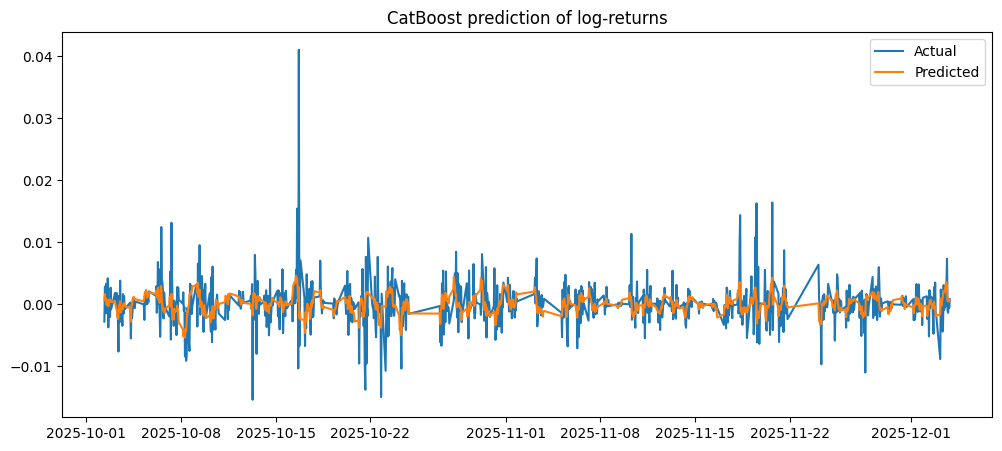

In [89]:
cat_model = CatBoostRegressor(
**{'min_data_in_leaf': 4, 'depth': 6, 'learning_rate': 0.07257827835801051, 'loss_function':'RMSE', 'random_seed':21, 'iterations':1000, 'verbose':100}
)


cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

pred_cat = cat_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred_cat))
print("CatBoost RMSE:", rmse)

r2 = r2_score(y_test, pred_cat)
print("CatBoost R2:", r2)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_cat, label='Predicted')
plt.legend()
plt.title("CatBoost prediction of log-returns")
plt.show()

In [90]:
from lightgbm import LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 22900, number of used features: 97
[LightGBM] [Info] Start training from score 0.000019
LGBM RMSE: 0.0031040601501472753
LGBM R2: 0.19372432985407428


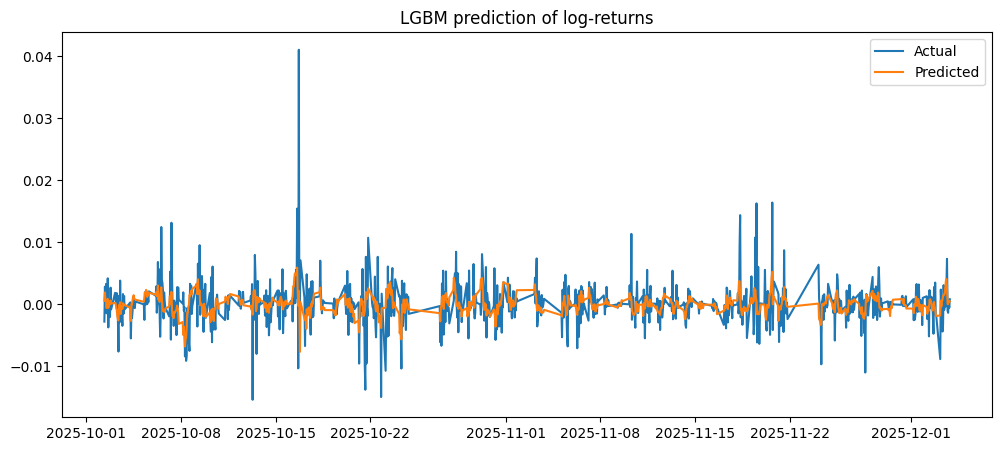

In [91]:
lgb_model = LGBMRegressor(
    min_child_samples=20,
    max_depth=10,
    learning_rate=0.0557827835801051,
    objective='regression',
    random_state=21,
    n_estimators=400,
    num_leaves=20
)
lgb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

pred_lgb = lgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred_lgb))
print("LGBM RMSE:", rmse)

r2 = r2_score(y_test, pred_lgb)
print("LGBM R2:", r2)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_lgb, label='Predicted')
plt.legend()
plt.title("LGBM prediction of log-returns")
plt.show()

In [92]:
from xgboost import XGBRegressor

LGBM RMSE: 0.0030584582782915625
LGBM R2: 0.21724037032849952


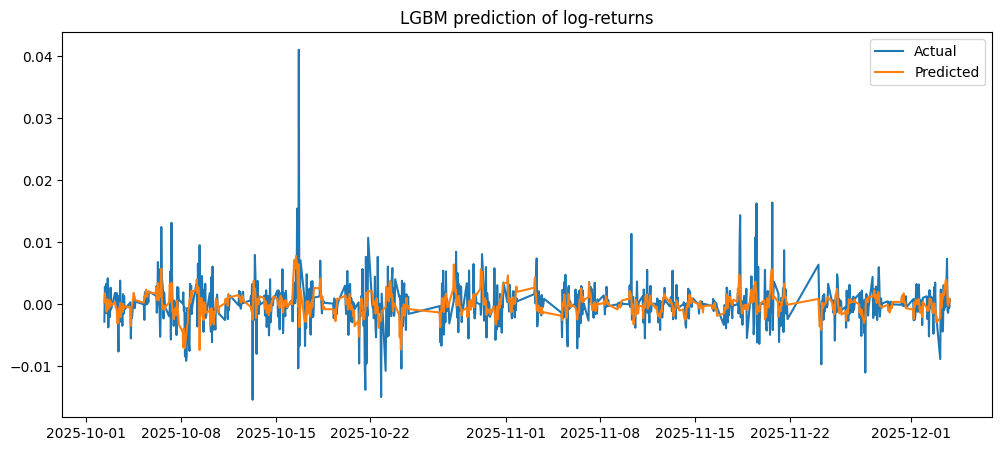

In [93]:
xgb_model = XGBRegressor(
    # min_child_samples=20,
    max_depth=6,
    learning_rate=0.0557827835801051,
    objective='reg:squarederror',
    random_state=21,
    n_estimators=400,
    # num_leaves=20,
)
xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print("LGBM RMSE:", rmse)

r2 = r2_score(y_test, pred_xgb)
print("LGBM R2:", r2)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_xgb, label='Predicted')
plt.legend()
plt.title("LGBM prediction of log-returns")
plt.show()

In [94]:
pred_all = np.mean(pd.DataFrame({'cat' : pred_cat, 'lgb' : pred_lgb, 'xgb' : pred_xgb}), axis=1)

rmse = np.sqrt(mean_squared_error(y_test, pred_all))
print("LGBM RMSE:", rmse)

r2 = r2_score(y_test, pred_all)
print("LGBM R2:", r2)

LGBM RMSE: 0.003065865450264144
LGBM R2: 0.21344430336260778


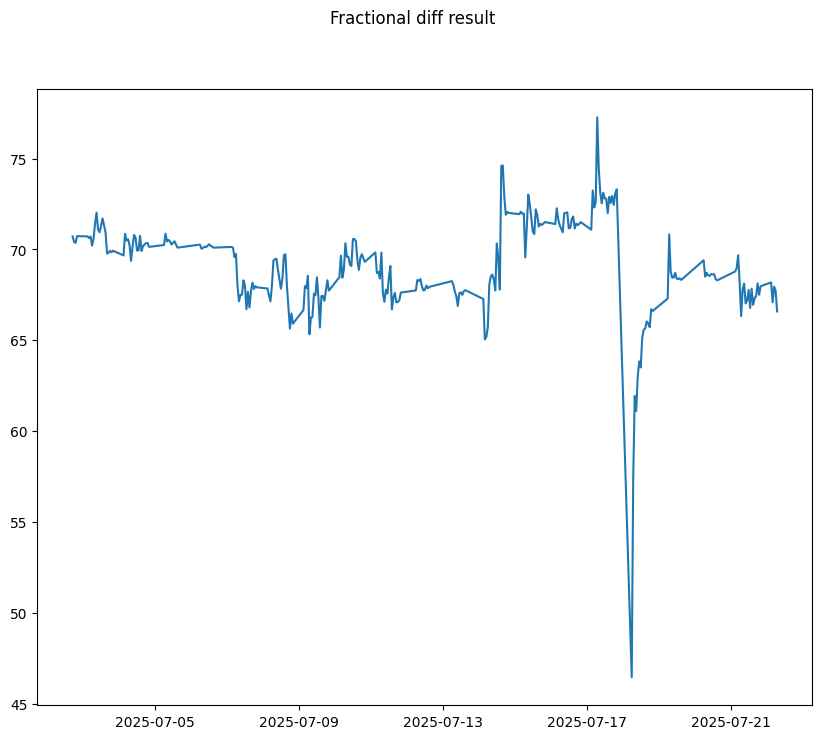

65


In [81]:
# stat = FracDiffModel(data=data_train, log_smooth=False, diff_amt = 0.3, thresh=0.001).fit()
# components_fd = stat.get_components(make_plot=True, last_ticks_plot=300)
# print(components_fd['residual'].isna().sum())